In [6]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

from verstack import NaNImputer
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import train_test_split

In [7]:
# Directory config to project root to insure consistency across environments for project specific imports
from pyprojroot import here
os.chdir(here())

# Project specific imports
from src.utils.utils import save_dataframe


## Data Quering and Loading

In [8]:
# DB related imports
from database.utils import init_db
from config.config_loader import load_config
from database.queries import prepped_data_query
from sqlalchemy import text

# Initialize local PostgreSQL session
Session = init_db(load_config("DB_URL"))
session = Session()

# Execute and fetch results
data = session.execute(text(prepped_data_query))

# Close the DB session
session.close()

# Convert to DataFrame
data = pd.DataFrame(data.fetchall(), columns=data.keys())

# Saving cleaned dataset for future use
save_dataframe(data, "0_base_data.csv")

✅ Data successfully saved to ./data\0_base_data.csv with separator ','


In [9]:
# Load dataset
data = pd.read_csv("./data/0_base_data.csv")

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11095 entries, 0 to 11094
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    11095 non-null  object 
 1   release_date             11095 non-null  object 
 2   tmdb_vote_count          11095 non-null  int64  
 3   tmdb_vote_average        11095 non-null  float64
 4   genre_names              11094 non-null  object 
 5   budget                   7079 non-null   float64
 6   revenue                  7765 non-null   float64
 7   runtime_in_min           11092 non-null  float64
 8   tmdb_popularity          11095 non-null  float64
 9   production_company_name  11049 non-null  object 
 10  production_country_name  11088 non-null  object 
 11  spoken_languages         11092 non-null  object 
 12  director                 11089 non-null  object 
 13  writer                   11003 non-null  object 
 14  actors                

In [11]:
# Count missing values
data.isnull().sum()

title                         0
release_date                  0
tmdb_vote_count               0
tmdb_vote_average             0
genre_names                   1
budget                     4016
revenue                    3330
runtime_in_min                3
tmdb_popularity               0
production_company_name      46
production_country_name       7
spoken_languages              3
director                      6
writer                       92
actors                        8
imdb_rating                  19
imdb_votes                   10
metascore                  2889
age_rating                  839
awards                     1863
rotten_tomatoes_rating     1738
meta_critic_rating         2889
dtype: int64

## Exploration of missing data

I have gotten to know this data during the collection process but there are a few aspects I'd like to look into in more detail. Unfortunately, there seems to be quite a bit of missing data, especially in the `budget` and `revenue` columns which I intend to be my main prediction targets when training models. It is not a huge surprise, however, since companies tend to be quite guarded around the financial data of their projects. I will be looking into other sources of financial data in future.

Let's have a look at the total amount of missing data. Hopefully the blanks between the two interect.

In [12]:
# Assuming 'data' is your DataFrame
missing_budget_revenue_count = data[data['budget'].isna() & data['revenue'].isna()].shape[0]
missing_budget_count = data['budget'].isna().sum() - missing_budget_revenue_count
missing_revenue_count = data['revenue'].isna().sum() - missing_budget_revenue_count

# Calculate the total number of rows with missing values in either 'budget' or 'revenue'
total_missing_count = missing_budget_count + missing_revenue_count + missing_budget_revenue_count

print(f"- Number of rows where both budget and revenue are missing: {missing_budget_revenue_count}")
print(f"- Number of additional rows where budget is missing: {missing_budget_count}")
print(f"- Number of additional rows where revenue is missing: {missing_revenue_count}")
print(f"Total number of rows with missing values in either budget or revenue: {total_missing_count}")

- Number of rows where both budget and revenue are missing: 2648
- Number of additional rows where budget is missing: 1368
- Number of additional rows where revenue is missing: 682
Total number of rows with missing values in either budget or revenue: 4698


There is indeed an unfortunate number of blanks. Most of them intersxect between the two columns but we still end up with about 30-35% of missing between the two so that is something I'll have to work around.

Let's have a look at the amount of rows missing financial data throughout time. I have a sneaking suspicion that it will be more common to not report financial data in more recent years.

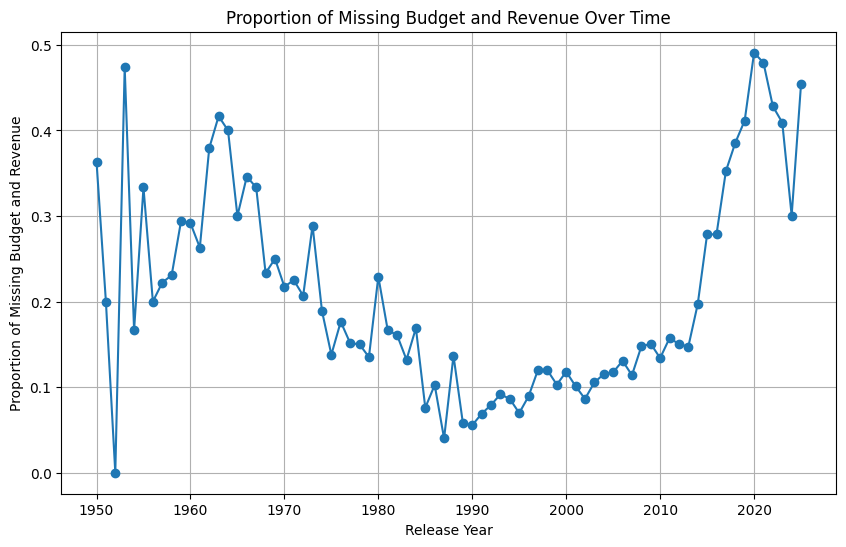

In [13]:
# Assuming 'data' is your DataFrame
plot_data = data.copy()
plot_data['release_date'] = pd.to_datetime(plot_data['release_date'])

# Create a new column to indicate if both budget and revenue are missing
plot_data['missing_budget_revenue'] = plot_data['budget'].isna() & plot_data['revenue'].isna()

# Group by release year and calculate the proportion of missing values
plot_data['release_year'] = plot_data['release_date'].dt.year
missing_by_year = plot_data.groupby('release_year')['missing_budget_revenue'].mean()

# Plot the proportion of missing values over time
plt.figure(figsize=(10, 6))
plt.plot(missing_by_year.index, missing_by_year.values, marker='o', linestyle='-')
plt.xlabel('Release Year')
plt.ylabel('Proportion of Missing Budget and Revenue')
plt.title('Proportion of Missing Budget and Revenue Over Time')
plt.grid(True)
plt.show()

I find it quite interesting that movie financial data has not been reported as frequently in recent years, especially around the COVID-19 pandemic. The movie industry has grown significantly, and so have the costs of producing films. Nowadays, blockbuster movies are often financed through external companies, making financial details a more sensitive topic. During the pandemic, the movie industry contracted, and the quality of movies declined. Consequently, movies have not been performing well financially of late, and companies like Disney may choose not to report this information to protect their stock value.

In [14]:
# data = data.dropna(subset=['imdb_votes'])
# data['imdb_votes'] = data['imdb_votes'].str.replace(',', '').astype(int)

# Limit to the top 20 movies
top_movies = data[data['revenue'].isnull()].sort_values(by='tmdb_vote_count', ascending=False).head(20)

# Create a pivot table
pivot_table = top_movies.pivot_table(index='title', values=['revenue', 'budget', 'tmdb_vote_count', 'release_date'], aggfunc='first')

# Sort the pivot table by tmdb_vote_count
sorted_pivot_table = pivot_table.sort_values(by='tmdb_vote_count', ascending=False)

# Print the result
print(sorted_pivot_table)

                                        budget release_date  tmdb_vote_count
title                                                                       
Zack Snyder's Justice League        70000000.0   2021-03-18            10134
Bird Box                            19800000.0   2018-12-13            10035
To All the Boys I've Loved Before          NaN   2018-08-16             8458
The Kissing Booth                          NaN   2018-05-11             7245
Prey                                65000000.0   2022-08-02             6880
Extraction                          65000000.0   2020-04-23             6151
Enola Holmes                        21000000.0   2020-09-23             6099
Bright                              90000000.0   2017-12-22             5695
The Kissing Booth 2                        NaN   2020-07-24             5016
El Camino: A Breaking Bad Movie            NaN   2019-10-11             4985
6 Underground                      150000000.0   2019-12-10             4807

## Multilable Categorical Features

There are a nuymber of multilable categorical features that will need to be looked into.

In [15]:
def count_unique_values_for_feature(df: pd.DataFrame, feature: str, delimiter: str = ",") -> int:
    """
    Splits the specified feature column by the delimiter and returns the number of unique values.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        feature (str): The name of the column to process.
        delimiter (str): The delimiter used to separate multiple values in the column.

    Returns:
        int: The number of unique values.
    """
    return len(df[feature].dropna().str.split(rf"{delimiter}\s*").explode().unique())

# List of features you want to analyze:
features = [
    "genre_names", 
    "production_company_name", "production_country_name", 
            "spoken_languages", "director", "writer", "actors"]

# Create a dictionary with the counts for each feature:
unique_counts = {feature: count_unique_values_for_feature(data, feature) for feature in features}

# Display the results:
for feature, count in unique_counts.items():
    print(f"{feature}: {count} unique values")

genre_names: 19 unique values
production_company_name: 11209 unique values
production_country_name: 110 unique values
spoken_languages: 117 unique values
director: 5280 unique values
writer: 12539 unique values
actors: 13125 unique values


Some of these features contain thousands of unique values, making it impractical to encode them directly. A good approach is to analyze the distribution of observations per category and retain only the most frequent categories. The less frequent categories can be grouped into a single **"Other"** category. This method helps to reduce the dimensionality of the data while preserving the most significant information.

Let's take a look at the distributions per category:

In [16]:
def print_top_categories(df: pd.DataFrame, column: str, top_n: int, delimiter: str = ",", others_label: str = "Others") -> None:
    """
    Prints the top_n unique values from a multi-label column and the total count of values 
    that fall outside the top_n (which would be grouped as 'Others').

    Args:
        df (pd.DataFrame): The DataFrame containing your data.
        column (str): The name of the multi-label column.
        top_n (int): The number of top categories to display.
        delimiter (str): The delimiter separating multiple values (default is a comma).
        others_label (str): The label used for less frequent values.
    """
    # Split the column into individual values and count frequencies
    exploded = df[column].dropna().str.split(rf"{delimiter}\s*").explode().str.strip()
    counts = exploded.value_counts()
    
    # Get the top N categories and the sum for the rest
    top_categories = counts.head(top_n)
    others_count = counts[counts.index.difference(top_categories.index)].sum()
    
    print("--------------------------------------------------||")
    print(f"Top {top_n} unique values for '{column}':")
    print(top_categories)
    print(f"Total count of all other values (will be grouped as '{others_label}'): {others_count}")
    print("--------------------------------------------------||\n")


top_values = {
    "genre_names": 20,
    "production_company_name": 20,
    "production_country_name": 10,
    "spoken_languages": 10,
    "director": 20,
    "writer": 20,
    "actors": 20
}

for feature, top_n in top_values.items():
    print_top_categories(data, feature, top_n)

--------------------------------------------------||
Top 20 unique values for 'genre_names':
genre_names
Drama              4836
Comedy             4004
Thriller           2942
Action             2521
Romance            1794
Adventure          1781
Crime              1643
Horror             1631
Science Fiction    1329
Fantasy            1237
Family             1217
Mystery            1015
Animation           991
History             540
War                 339
Music               322
Documentary         191
TV Movie            161
Western             149
Name: count, dtype: int64
Total count of all other values (will be grouped as 'Others'): 0
--------------------------------------------------||

--------------------------------------------------||
Top 20 unique values for 'production_company_name':
production_company_name
Universal Pictures       549
Warner Bros. Pictures    542
Paramount Pictures       436
Columbia Pictures        422
20th Century Fox         385
Metro-Goldwyn-Mayer 

- `genre_names`: Will be kept as is since the number of unique categories is perfectly manageable.
- `production_company_name`: Has a relatively even distribution, making it more useful for specific company investigations rather than model training. Therefore, it will be discarded for model training.
- `production_country_name`: Most values are concentrated in the US and the UK, making it a great candidate for consolidating less frequent categories into an "Other" category.
- `spoken_languages`: Another candidate for consolidation, potentially grouping into the top 5 most common languages.
- `director`: Similar to `production_company_name`, it has a wide distribution and will be discarded for model training.

## Preprocessing Pipeline

For this project, I would like to make extensive use of the pipeline functionality in SciKit-Learn to re-familiarize myself with the tool. I will also be making use of `FunctionTransformer` to have custom steps be part of the final pipeline.

### NaNImputer from verstack

The `NaNImputer` from the `verstack` library is a tool designed to handle missing values in a DataFrame. It provides various strategies for imputing missing values, including simple statistical methods and more advanced techniques. It automates the entire process and makes decisions on its own about the best approach for each column.

Due to the nature of the data, each observation in columns like `budget`, `revenue`, and the various critic scores are very individual, and imputation strategies like **median** and **mean** will not be appropriate options. Therefore, I want to make use of machine learning algorithms. `NaNImputer` will make use of `IterativeImputer` for such values, making it a more robust option.

In [17]:
# Define a function to add missing indicators for certain columns.
def impute_data(df: pd.DataFrame, colums_to_exclude: list = None) -> pd.DataFrame:
    if colums_to_exclude:
        df = df.drop(columns=colums_to_exclude).copy()
    else:
        df.copy()
    imputer = NaNImputer()
    df = imputer.impute(df)
    return df

imputation_transformer = FunctionTransformer(impute_data, validate=False)

#### Data Types cionversion transformers

Some features need to be reformatted and below functions will deal with that.

In [18]:
# Some columns need to get converted to numeric
def convert_to_numeric(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col in df.columns:
        # Convert to string, remove commas, then convert to numeric
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
    return df

to_numeric = FunctionTransformer(convert_to_numeric, validate=False)

#### Missing indicator features
I want to set up binary features for the columns where I have a large number of blanks to be able to investigate the imputed data later on.

In [19]:
# Define a function to add missing indicators for certain columns.
def add_missing_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col in df.columns:
        df[col + "_missing"] = df[col].isnull().astype(int)
    return df

missing_indicator_transformer = FunctionTransformer(add_missing_indicators, validate=False)

# iter_cols = ['metascore', 'rotten_tomatoes_rating', 'meta_critic_rating', 'budget', 'revenue']

### Feature Engineering

#### Award features
The `awards` column can be used to extract various columns for BAFTAs, Oscars and total awards and nominations.

In [20]:
def extract_awards_info(awards_str):
    """
    Extracts numerical awards information from a text string.

    Parameters
    ----------
    awards_str : str
        The awards description string.

    Returns
    -------
    pd.Series
        A Series with the following index:
        ["total_wins", "total_noms", "oscar_wins", "oscar_noms", "bafta_wins", "bafta_noms"]
    """
    # Handle missing or "N/A" values.
    if pd.isna(awards_str) or awards_str.strip() in ["N/A", ""]:
        return pd.Series([0, 0, 0, 0, 0, 0],
                         index=["total_wins", "total_noms", "oscar_wins", "oscar_noms", "bafta_wins", "bafta_noms"])
    
    # Extract overall totals.
    # Look for a pattern like "56 wins" (we use negative lookahead to avoid picking up Oscar wins)
    total_wins_match = re.search(r'(\d+)\s+wins?(?!.*Oscars)', awards_str, flags=re.IGNORECASE)
    total_noms_match = re.search(r'(\d+)\s+nominations', awards_str, flags=re.IGNORECASE)
    total_wins = int(total_wins_match.group(1)) if total_wins_match else 0
    total_noms = int(total_noms_match.group(1)) if total_noms_match else 0

    # Oscar-specific extraction:
    oscar_noms_match = re.search(r'Nominated for\s+(\d+)\s+Oscars?', awards_str, flags=re.IGNORECASE)
    oscar_noms = int(oscar_noms_match.group(1)) if oscar_noms_match else 0
    # Look for something like "Oscars. 56 wins" or "Oscars 56 wins" (using non-digit separator)
    oscar_wins_match = re.search(r'Oscars?[\W_]+(\d+)\s+wins?', awards_str, flags=re.IGNORECASE)
    oscar_wins = int(oscar_wins_match.group(1)) if oscar_wins_match else 0

    # BAFTA-specific extraction:
    # For nominations, sometimes the text might run together (e.g. "BAFTA Award28 nominations total")
    bafta_noms_match = re.search(r'Nominated for\s+(\d+)\s*BAFTA', awards_str, flags=re.IGNORECASE)
    bafta_noms = int(bafta_noms_match.group(1)) if bafta_noms_match else 0
    # For wins, allow an optional "Award" word after BAFTA.
    bafta_wins_match = re.search(r'BAFTA(?:\s+Award)?[\D_]+(\d+)\s+wins?', awards_str, flags=re.IGNORECASE)
    bafta_wins = int(bafta_wins_match.group(1)) if bafta_wins_match else 0

    return pd.Series([total_wins, total_noms, oscar_wins, oscar_noms, bafta_wins, bafta_noms],
                     index=["total_wins", "total_noms", "oscar_wins", "oscar_noms", "bafta_wins", "bafta_noms"])


def transform_awards(X):
    """
    Expects X to be a DataFrame with a single column (e.g., 'awards').
    Applies extract_awards_info row-wise and returns a DataFrame.
    """
    # Apply the function to the first (and only) column
    return X.iloc[:, 0].apply(extract_awards_info)

# Wrap the function in a FunctionTransformer
awards_transformer = FunctionTransformer(transform_awards, validate=False)

#### Multi-lable categorical features adjustment

Below ``FunctionTransformer`` will group the given multi-lable feature into a top N + Others categories.

In [21]:
def transform_top_categories(X, column, top_n, delimiter=",", others_label="Others"):
    """
    Transforms a multi-label column by keeping only the top_n categories (based on frequency)
    and replacing all other categories with a generic label.
    
    Parameters:
        X (pd.DataFrame): Input DataFrame.
        column (str): The name of the multi-label column to process.
        top_n (int): Number of top categories to keep.
        delimiter (str): Delimiter separating the values.
        others_label (str): Label to assign to categories not among the top_n.
    
    Returns:
        pd.DataFrame: A DataFrame with one column (the processed column).
    """
    X = X.copy()
    # Split the column values, explode, and count frequencies.
    exploded = X[column].dropna().str.split(rf"{delimiter}\s*").explode().str.strip()
    counts = exploded.value_counts()
    top_categories = counts.head(top_n).index.tolist()
    
    def map_categories(cell):
        if pd.isna(cell):
            return cell
        # Split and strip each value.
        cats = [cat.strip() for cat in cell.split(delimiter)]
        # Replace values not in top_categories with others_label.
        new_cats = [cat if cat in top_categories else others_label for cat in cats]
        # Remove duplicates while preserving order.
        seen = set()
        new_cats = [x for x in new_cats if x not in seen and not seen.add(x)]
        return delimiter.join(new_cats)
    
    X[column] = X[column].apply(map_categories)
    # Return a DataFrame with just the transformed column.
    return X[[column]]

# Now, to create a FunctionTransformer for, say, the 'production_country_name' column with top_n=5:
transformer_prod_country = FunctionTransformer(
    func=partial(transform_top_categories, column="production_country_name", top_n=5, delimiter=",", others_label="Others"),
    validate=False
)

# Similarly, for 'spoken_languages' column with top_n=5:
transformer_spoken_lang = FunctionTransformer(
    func=partial(transform_top_categories, column="spoken_languages", top_n=5, delimiter=",", others_label="Others"),
    validate=False
)

#### Release date rework

`release_date` can be split int oseparate integer columns to be used during training later but binary features like `is_weekend` and `is_holiday` can also be derived.

In [22]:
def add_date_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month
    df['release_day'] = df['release_date'].dt.day
    df['is_weekend'] = (df['release_date'].dt.weekday >= 4).astype(int)
    df['is_holiday_season'] = df['release_month'].isin([6, 7, 11, 12]).astype(int)
    df['movie_age'] = 2025 - df['release_year']
    return df

# Wrap the function as a transformer
date_features_transformer = FunctionTransformer(add_date_features, validate=False)

#### Return on Investment
Great option for looking into the budget-revenue relationship

In [23]:
def calculate_roi(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['roi'] = (df['revenue'] - df['budget']) / df['budget']
    return df

# Wrap the function as a transformer
roi_transformer = FunctionTransformer(calculate_roi, validate=False)

#### `actors`, `directors` and `writers`

These features are quite valuable I think but they need to be reworked. I do know that IMDB has these ones ordered by importance and billing so we can get the most relevant people in each category.

In [24]:
def extract_actors(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['first_billing_actor'] = df['actors'].apply(lambda x: x.split(',')[0].strip() if pd.notnull(x) and len(x.split(',')) > 0 else None)
    df['second_billing_actor'] = df['actors'].apply(lambda x: x.split(',')[1].strip() if pd.notnull(x) and len(x.split(',')) > 1 else None)
    df['third_billing_actor'] = df['actors'].apply(lambda x: x.split(',')[2].strip() if pd.notnull(x) and len(x.split(',')) > 2 else None)
    return df.drop(columns=['actors'])

def extract_directors(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['main_director'] = df['director'].apply(lambda x: x.split(',')[0].strip() if pd.notnull(x) and len(x.split(',')) > 0 else None)
    df['secondary_director'] = df['director'].apply(lambda x: x.split(',')[1].strip() if pd.notnull(x) and len(x.split(',')) > 1 else None)
    return df.drop(columns=['director'])

def extract_writers(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['main_writer'] = df['writer'].apply(lambda x: x.split(',')[0].strip() if pd.notnull(x) and len(x.split(',')) > 0 else None)
    df['secondary_writer'] = df['writer'].apply(lambda x: x.split(',')[1].strip() if pd.notnull(x) and len(x.split(',')) > 1 else None)
    return df.drop(columns=['writer'])

# Create FunctionTransformers
actors_transformer = FunctionTransformer(extract_actors)
directors_transformer = FunctionTransformer(extract_directors)
writers_transformer = FunctionTransformer(extract_writers)

#### Dropper
Seetting up a dropper transformer that can be used in a pipeline

In [25]:
# Define a function transformer to drop unwanted columns.
def drop_unwanted_columns(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    return df.drop(columns=columns, errors='ignore')

columns_to_drop = ['production_company_name', 'director', 'writer', 'actors', 'title', 'release_date']

dropper = FunctionTransformer(drop_unwanted_columns, kw_args={'columns': columns_to_drop})

### Main ColumnTransformer
This `ColumnTransformer` will apply the included steps simultaniously. Each step relies on its own set of features so there is no overlap and no chance of issues. `Pipeline` applies the step in order which I will make use of later on.

In [26]:
main_transformer = ColumnTransformer(
    transformers=[
        ('missing_indicator', missing_indicator_transformer, ['metascore', 'rotten_tomatoes_rating', 'meta_critic_rating', 'budget', 'revenue']),
        ('awards', awards_transformer, ['awards']),
        ('date_feature_engineering', date_features_transformer, ['release_date']),
        ('top_n_prod_country', transformer_prod_country, ['production_country_name']),
        ('top_n_spoken_lang', transformer_spoken_lang, ['spoken_languages']),
        ('actors', actors_transformer, ['actors']),
        ('directors', directors_transformer, ['director']),
        ('writers', writers_transformer, ['writer']),
        ('to_numeric', to_numeric, ['imdb_rating', 'imdb_votes'])
    ],
    remainder='passthrough', 
    verbose_feature_names_out=False
)

# Set output to pandas dataframe
main_transformer.set_output(transform='pandas')

# Apply the preprocessor to the data
# clean_data = main_transformer.fit_transform(data)
# clean_data.head()

ColumnTransformer(remainder='passthrough',
                  transformers=[('missing_indicator',
                                 FunctionTransformer(func=<function add_missing_indicators at 0x0000016FDAC5DD00>),
                                 ['metascore', 'rotten_tomatoes_rating',
                                  'meta_critic_rating', 'budget', 'revenue']),
                                ('awards',
                                 FunctionTransformer(func=<function transform_awards at 0x0000016FDAC5F100>),
                                 ['awards']),
                                ('date_feature_engi...
                                 ['actors']),
                                ('directors',
                                 FunctionTransformer(func=<function extract_directors at 0x0000016FDAC5E700>),
                                 ['director']),
                                ('writers',
                                 FunctionTransformer(func=<function extract_writers at 0x0000016FDAC5E3E0>),
                                 ['writer']),
                                ('to_numeric',
                                 FunctionTransformer(func=<function convert_to_numeric at 0x0000016FDAC5ECA0>),
                                 ['imdb_rating', 'imdb_votes'])],
                  verbose_feature_names_out=False)

In [27]:
clean_data = main_transformer.fit_transform(data)
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11095 entries, 0 to 11094
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   metascore                       8206 non-null   float64       
 1   rotten_tomatoes_rating          9357 non-null   float64       
 2   meta_critic_rating              8206 non-null   float64       
 3   budget                          7079 non-null   float64       
 4   revenue                         7765 non-null   float64       
 5   metascore_missing               11095 non-null  int64         
 6   rotten_tomatoes_rating_missing  11095 non-null  int64         
 7   meta_critic_rating_missing      11095 non-null  int64         
 8   budget_missing                  11095 non-null  int64         
 9   revenue_missing                 11095 non-null  int64         
 10  total_wins                      11095 non-null  int64         
 11  to

### Pipeline

#### Full data pipeline

The main transformer will be applied so that all the feature transformations and engineering gets applied on actual data and then all the missing data will be imputed. I like this order because it makes sure the generated features are all based on real data. 

I would like to experiment a bit with various inputs of the imputation to study the effects on model performance and prediction. Let's start with running the imputation on all available data simultaniously.

In [28]:
# Setting up pipeline
imputation_pipeline = Pipeline(steps=[
    # ('main_transformer', main_transformer),
    ('impute_data', imputation_transformer),
    # ('roi_feature_engineering', roi_transformer),
    # ('dropper', dropper)
])

# Set output to pandas dataframe
imputation_pipeline.set_output(transform='pandas')

Pipeline(steps=[('impute_data',
                 FunctionTransformer(func=<function impute_data at 0x0000016FDAC5FCE0>))])

In [29]:
imputed_data_full = imputation_pipeline.fit_transform(clean_data)


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         11095
     .. columns:      42
     .. mb in memory: 3.39
     .. NaN cols num: 20

   - Drop hopeless NaN cols

   - droped column secondary_director with NaNs and a constant non-NaN value
     . Missing values in spoken_languages replaced by "Missing_data" string
     . Missing values in first_billing_actor replaced by "Missing_data" string
     . Missing values in second_billing_actor replaced by "Missing_data" string
     . Missing values in third_billing_actor replaced by "Missing_data" string
     . Missing values in main_director replaced by "Missing_data" string
     . Missing values in main_writer replaced by "Missing_data" string
     . Missing values in secondary_writer replaced by "Missing_data" string
     . Missing values in genre_names replaced by "Missing_data" string
     . Missing values in production_company_name replaced by "Missing_data" string

   - Processing whole data for imputati

In [30]:
imputed_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11095 entries, 0 to 11094
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   metascore                       11095 non-null  float64       
 1   rotten_tomatoes_rating          11095 non-null  float64       
 2   meta_critic_rating              11095 non-null  float64       
 3   budget                          11095 non-null  float64       
 4   revenue                         11095 non-null  float64       
 5   metascore_missing               11095 non-null  int64         
 6   rotten_tomatoes_rating_missing  11095 non-null  int64         
 7   meta_critic_rating_missing      11095 non-null  int64         
 8   budget_missing                  11095 non-null  int64         
 9   revenue_missing                 11095 non-null  int64         
 10  total_wins                      11095 non-null  int64         
 11  to

In [31]:
# Saving cleaned dataset for future use
save_dataframe(imputed_data_full, "1.1_imputed_data_full.csv")

✅ Data successfully saved to ./data\1.1_imputed_data_full.csv with separator ','


#### No Revenue Pipeline
Let's exclude the target of my predictive modelimg which will be `revenue` to make sure the model cannot gain any information due to the reelations created by the imputation.

In [32]:
imputed_data_no_revenue = imputation_pipeline.fit_transform(clean_data.drop(columns=['revenue', 'revenue_missing']))


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         11095
     .. columns:      40
     .. mb in memory: 3.22
     .. NaN cols num: 19

   - Drop hopeless NaN cols

   - droped column secondary_director with NaNs and a constant non-NaN value
     . Missing values in spoken_languages replaced by "Missing_data" string
     . Missing values in first_billing_actor replaced by "Missing_data" string
     . Missing values in second_billing_actor replaced by "Missing_data" string
     . Missing values in third_billing_actor replaced by "Missing_data" string
     . Missing values in main_director replaced by "Missing_data" string
     . Missing values in main_writer replaced by "Missing_data" string
     . Missing values in secondary_writer replaced by "Missing_data" string
     . Missing values in genre_names replaced by "Missing_data" string
     . Missing values in production_company_name replaced by "Missing_data" string

   - Processing whole data for imputati

In [33]:
imputed_data_no_revenue['revenue'] = clean_data['revenue']
imputed_data_no_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11095 entries, 0 to 11094
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   metascore                       11095 non-null  float64       
 1   rotten_tomatoes_rating          11095 non-null  float64       
 2   meta_critic_rating              11095 non-null  float64       
 3   budget                          11095 non-null  float64       
 4   metascore_missing               11095 non-null  int64         
 5   rotten_tomatoes_rating_missing  11095 non-null  int64         
 6   meta_critic_rating_missing      11095 non-null  int64         
 7   budget_missing                  11095 non-null  int64         
 8   total_wins                      11095 non-null  int64         
 9   total_noms                      11095 non-null  int64         
 10  oscar_wins                      11095 non-null  int64         
 11  os

In [34]:
# Saving cleaned dataset for future use
save_dataframe(imputed_data_no_revenue, "1.2_imputed_data_no_revenue.csv")

✅ Data successfully saved to ./data\1.2_imputed_data_no_revenue.csv with separator ','


### Split data Imputation

In [35]:
clean_data = clean_data.dropna(subset=['revenue'])

target = 'revenue'
X = clean_data.drop(columns=[target, 'revenue_missing'], axis=1)
y = clean_data[target]


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [37]:
split_pipeline = imputation_pipeline.fit(X, y)
X_train_imputed = split_pipeline.transform(X_train)
X_test_imputed = split_pipeline.transform(X_test)


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         6600
     .. columns:      40
     .. mb in memory: 1.96
     .. NaN cols num: 15

   - Drop hopeless NaN cols

   - droped column secondary_director with NaNs and a constant non-NaN value
     . Missing values in first_billing_actor replaced by "Missing_data" string
     . Missing values in second_billing_actor replaced by "Missing_data" string
     . Missing values in third_billing_actor replaced by "Missing_data" string
     . Missing values in main_director replaced by "Missing_data" string
     . Missing values in main_writer replaced by "Missing_data" string
     . Missing values in secondary_writer replaced by "Missing_data" string
     . Missing values in genre_names replaced by "Missing_data" string
     . Missing values in production_company_name replaced by "Missing_data" string

   - Processing whole data for imputation

   - Imputing single core 6 cols
     . Imputed (regression) - 801      N

In [38]:
X_train_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6600 entries, 8292 to 10333
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   metascore                       6600 non-null   float64       
 1   rotten_tomatoes_rating          6600 non-null   float64       
 2   meta_critic_rating              6600 non-null   float64       
 3   budget                          6600 non-null   float64       
 4   metascore_missing               6600 non-null   int64         
 5   rotten_tomatoes_rating_missing  6600 non-null   int64         
 6   meta_critic_rating_missing      6600 non-null   int64         
 7   budget_missing                  6600 non-null   int64         
 8   total_wins                      6600 non-null   int64         
 9   total_noms                      6600 non-null   int64         
 10  oscar_wins                      6600 non-null   int64         
 11  oscar

In [39]:
X_test_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1165 entries, 9918 to 2602
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   metascore                       1165 non-null   float64       
 1   rotten_tomatoes_rating          1165 non-null   float64       
 2   meta_critic_rating              1165 non-null   float64       
 3   budget                          1165 non-null   float64       
 4   metascore_missing               1165 non-null   int64         
 5   rotten_tomatoes_rating_missing  1165 non-null   int64         
 6   meta_critic_rating_missing      1165 non-null   int64         
 7   budget_missing                  1165 non-null   int64         
 8   total_wins                      1165 non-null   int64         
 9   total_noms                      1165 non-null   int64         
 10  oscar_wins                      1165 non-null   int64         
 11  oscar_

In [40]:
# Saving cleaned dataset for future use
save_dataframe(X_train_imputed, "1.3.1_X_train_imputed.csv")
save_dataframe(X_test_imputed, "1.3.2_X_test_imputed.csv")
save_dataframe(y_train, "1.3.3_y_train.csv")
save_dataframe(y_test, "1.3.4_y_test.csv")

✅ Data successfully saved to ./data\1.3.1_X_train_imputed.csv with separator ','
✅ Data successfully saved to ./data\1.3.2_X_test_imputed.csv with separator ','
✅ Data successfully saved to ./data\1.3.3_y_train.csv with separator ','
✅ Data successfully saved to ./data\1.3.4_y_test.csv with separator ','
